Для начала импортируем всё, что нам пригодится

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as mpatches
sns.set_style("white")

Устанавливаем параметры

In [4]:
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [15., 6.]

Импортируем нужные данные

In [5]:
battles = pd.read_csv("battles.csv")
character_deaths = pd.read_csv("character-deaths.csv")
character_predictions = pd.read_csv("character-predictions.csv")

# И мы готовы начать!

### Заметка себе - создаю дополнительные колнки для более полного анализа:

defender_count - количество главных домов на стороне защиты

attacker_count - Количество основных домов на стороне атакующего

att_comm_count - количество командиров атакующей стороны

no_of_books - количество книг, в которых появился персонаж



In [7]:
battles.loc[:, "defender_count"] = (4 - battles[["defender_1", "defender_2", "defender_3", "defender_4"]].isnull().sum(axis = 1))
battles.loc[:, "attacker_count"] = (4 - battles[["attacker_1", "attacker_2", "attacker_3", "attacker_4"]].isnull().sum(axis = 1))
battles.loc[:, "att_comm_count"] = [len(x) if type(x) == list else np.nan for x in battles.attacker_commander.str.split(",")]
character_predictions.loc[:, "no_of_books"] = character_predictions[[x for x in character_predictions.columns if x.startswith("book")]].sum(axis = 1)

## Смотрим главные события по годам (смерть или захват)

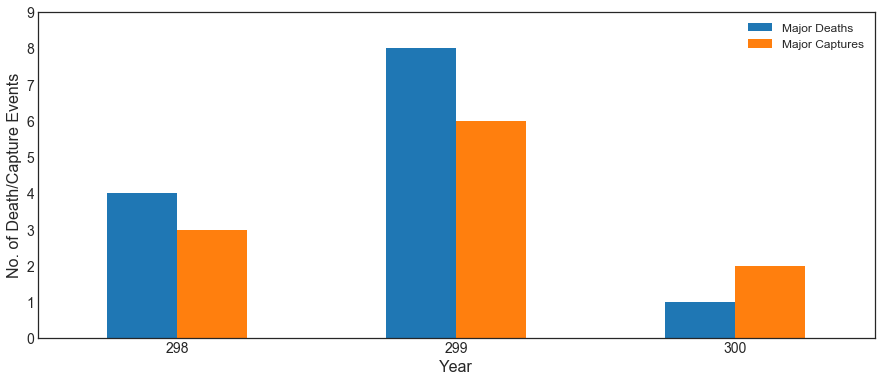

In [8]:
p = battles.groupby('year').sum()[["major_death", "major_capture"]].plot.bar(rot = 0)
_ = p.set(xlabel = "Year", ylabel = "No. of Death/Capture Events", ylim = (0, 9)), p.legend(["Major Deaths", "Major Captures"])

Ого, 299 - самый насыщенный

## А какая зависимость между исходом сражения и размером армии?

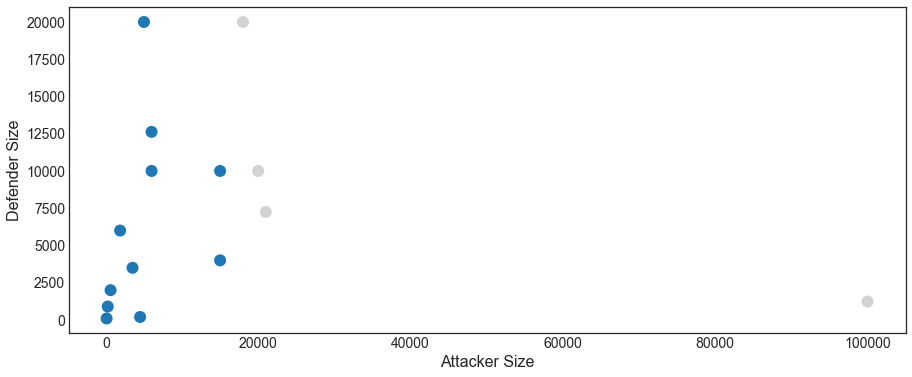

In [10]:
data = battles.dropna(axis = 0, subset = ["attacker_size", "defender_size", "attacker_outcome"]).copy(deep = True)
colors = [sns.color_palette()[0] if x == "win" else "lightgray" for x in data.attacker_outcome.values]
p = data.plot.scatter("attacker_size", "defender_size", c = colors, s = 100, lw = 2.)
_ = p.set(xlabel = "Attacker Size", ylabel = "Defender Size")

Хмм, неоднозначно

## А как часто на атакующей стороне было больше одного крупного дома?

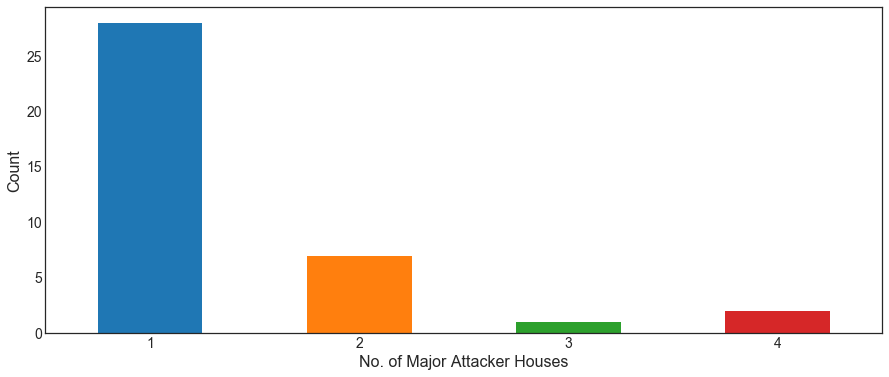

In [11]:
p = battles.attacker_count.value_counts().sort_index().plot.bar(rot = 0)
_ = p.set(xlabel = "No. of Major Attacker Houses", ylabel = "Count")

Я думала, что намного чаще, но, оказывается, часто воевали в одиночку!

## Какие же пары домов чаще всего вступали в открытый конфликт?

Игнорируем записи, в которых параметр attacker_king или defender_king равен нулю. Также игнорируем одну запись, где обе имеют одинаковое значение.

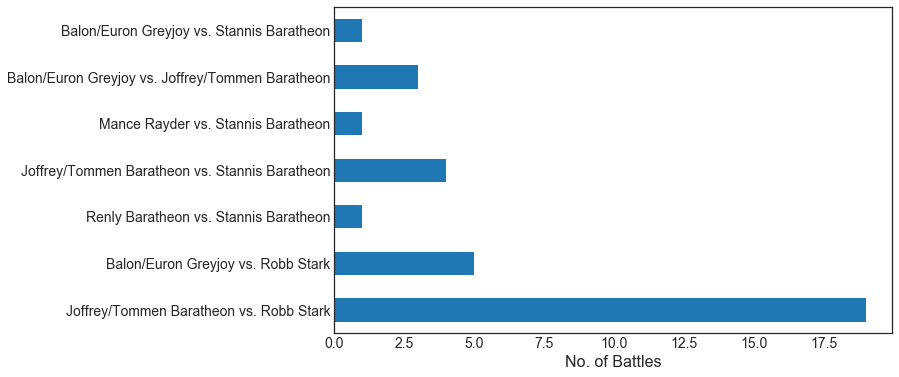

In [12]:
c = list(Counter([tuple(set(x)) for x in battles.dropna(subset = ["attacker_king", "defender_king"])[["attacker_king", "defender_king"]].values if len(set(x)) > 1]).items())
p = pd.DataFrame(c).plot.barh(figsize = (10, 6))
_ = p.set(yticklabels = ["%s vs. %s" % (x[0], x[1]) for x in list(zip(*c))[0]], xlabel = "No. of Battles"), p.legend("")

На 1 месте Баратеоны и Старки, на 2 Грейджои и Старки. Хммм, любопытно, а это связано с тем, что в итоге Старки победили?

## Сколько командиров было у армий разных королей?

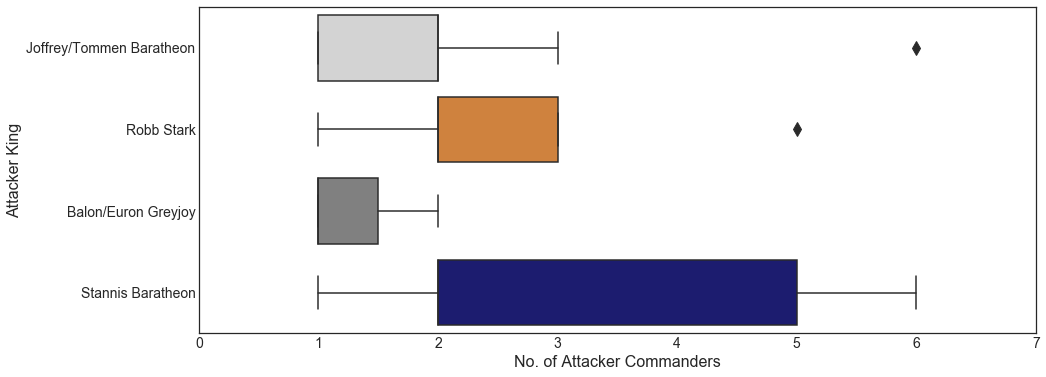

In [14]:
p = sns.boxplot("att_comm_count", "attacker_king", data = battles, saturation = .6, fliersize = 10., palette = ["lightgray", sns.color_palette()[1], "grey", "darkblue"])
_ = p.set(xlabel = "No. of Attacker Commanders", ylabel = "Attacker King", xticks = range(8))


У Станиса было больше всего командиров. Ожидаемо :)

## Сколько крупных событий смерти / захвата происходит в каждом регионе?

C:\Users\Tatiana\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


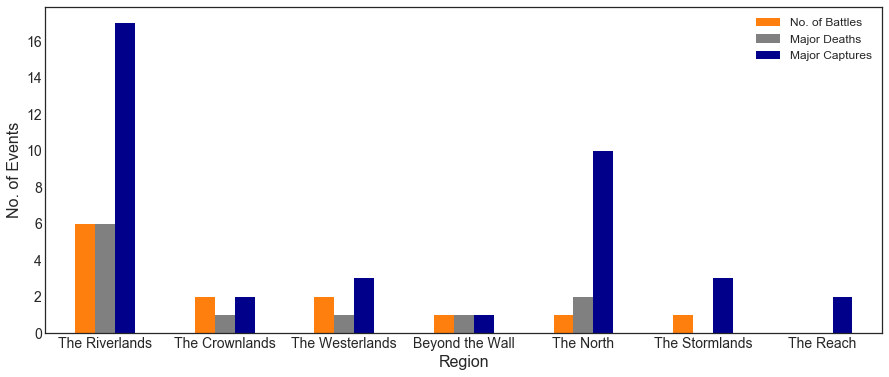

In [15]:
data = battles.groupby("region").sum()[["major_death", "major_capture"]]
p = pd.concat([data, battles.region.value_counts().to_frame()], axis = 1).sort_values("major_death", ascending = False).copy(deep = True).plot.bar(color = [sns.color_palette()[1], "grey", "darkblue"], rot = 0)
_ = p.set(xlabel = "Region", ylabel = "No. of Events"), p.legend(["No. of Battles", "Major Deaths", "Major Captures"], fontsize = 12.)

В Ривердейле самые большие потери, но ведь позиции тоже ключевые!

## Как появление в других книгах относится к выживанию?

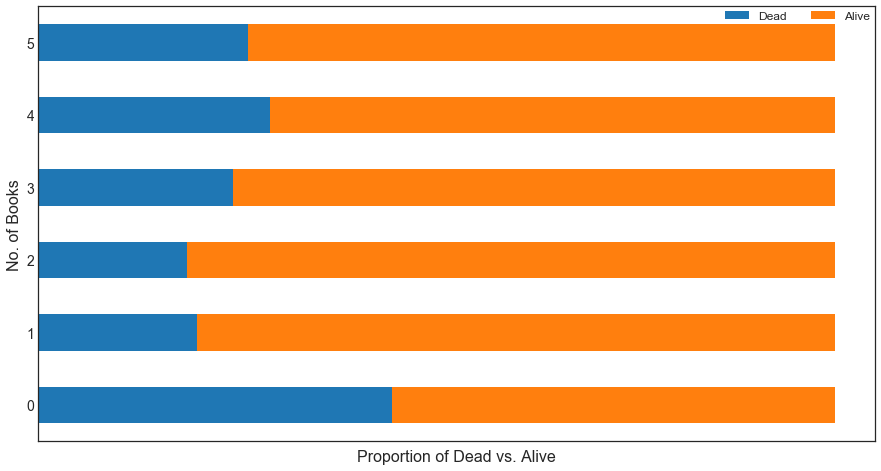

In [16]:
data = character_predictions.groupby(["no_of_books", "isAlive"]).count()["S.No"].unstack().copy(deep = True)
p = data.div(data.sum(axis = 1), axis = 0).plot.barh(stacked = True, rot = 0, figsize = (15, 8), width = .5)
_ = p.set(xticklabels = "", ylabel = "No. of Books", xlabel = "Proportion of Dead vs. Alive"), p.legend(["Dead", "Alive"], loc = "upper right", ncol = 2, borderpad = -.15)

Самой ненасыщенной по количествам смертей была первая (нулевая) книга, а самой жестокой - третья (вторая)

## Какова связь между популярностью, количеством отношений с умершими и возрастом?
Учитываем только записи с действительным возрастом

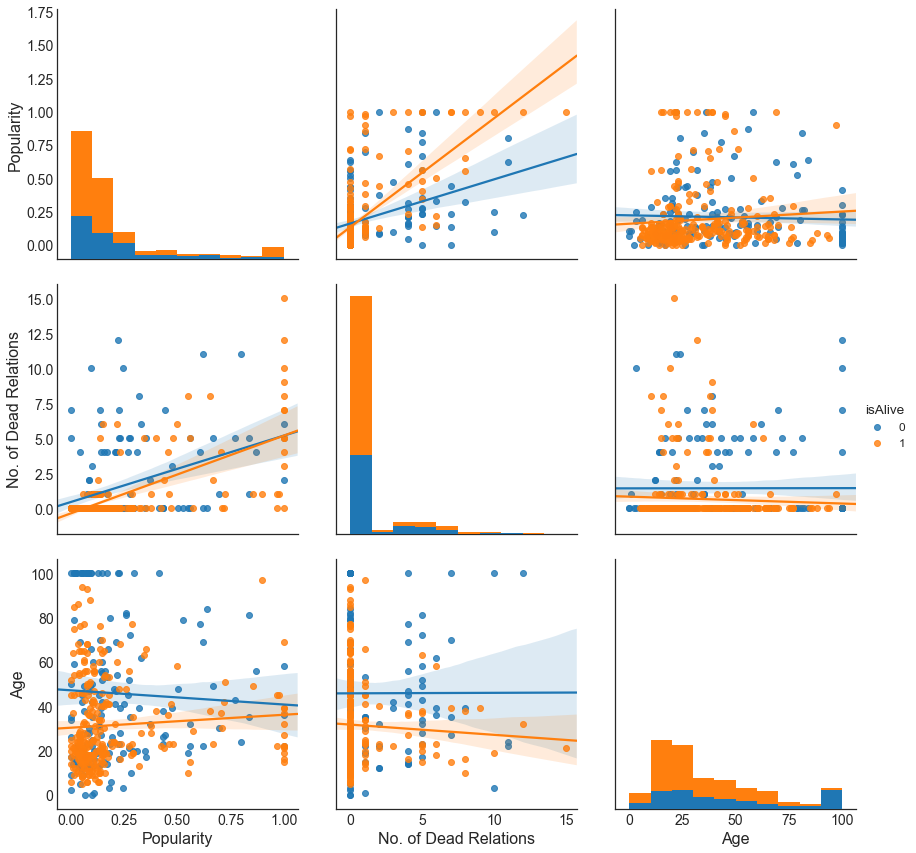

In [17]:
p = sns.pairplot(character_predictions[(character_predictions.age >= 0)][["popularity", "numDeadRelations", "age", "isAlive"]], hue = "isAlive", vars = ["popularity", "numDeadRelations", "age"], kind = "reg", size = 4.)
_ = p.axes[0][0].set_ylabel("Popularity"), p.axes[1][0].set_ylabel("No. of Dead Relations"), p.axes[2][0].set_ylabel("Age")
_ = p.axes[2][0].set_xlabel("Popularity"), p.axes[2][1].set_xlabel("No. of Dead Relations"), p.axes[2][2].set_xlabel("Age")

Уффф, интересно!

## Как культура связана с выживанием?

Для этого мы будем переименовывать культуры, используя знание предметной области, поскольку многие культурные ценности соответствуют одной культуре.

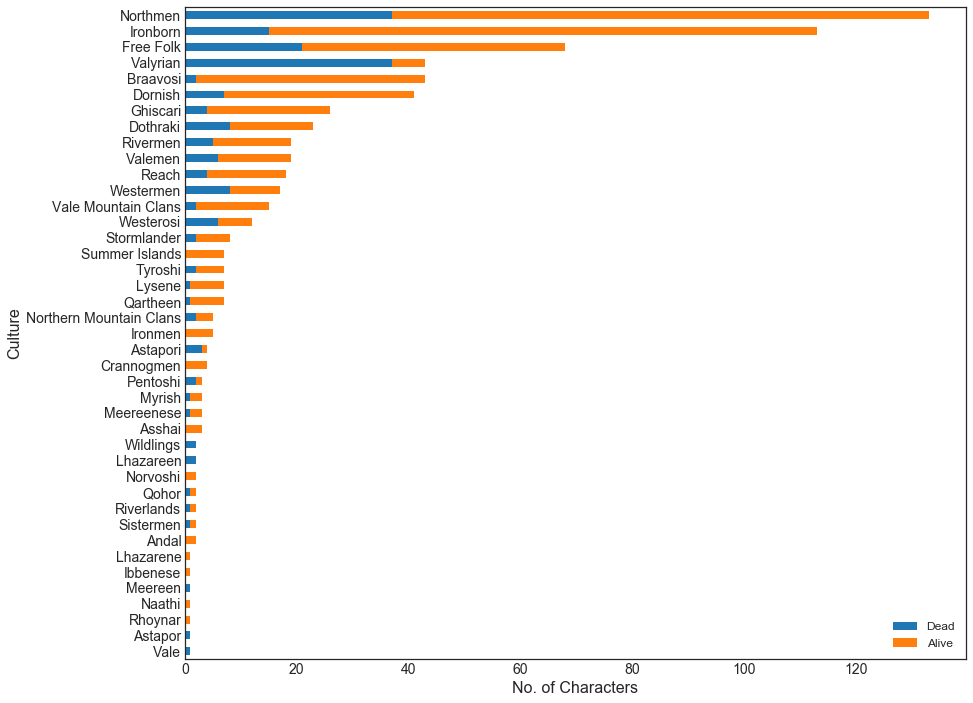

In [21]:
cult = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari': ['ghiscari', 'ghiscaricari',  'ghis'],
    'Asshai': ["asshai'i", 'asshai'],
    'Lysene': ['lysene', 'lyseni'],
    'Andal': ['andal', 'andals'],
    'Braavosi': ['braavosi', 'braavos'],
    'Dornish': ['dornishmen', 'dorne', 'dornish'],
    'Myrish': ['myr', 'myrish', 'myrmen'],
    'Westermen': ['westermen', 'westerman', 'westerlands'],
    'Westerosi': ['westeros', 'westerosi'],
    'Stormlander': ['stormlands', 'stormlander'],
    'Norvoshi': ['norvos', 'norvoshi'],
    'Northmen': ['the north', 'northmen'],
    'Free Folk': ['wildling', 'first men', 'free folk'],
    'Qartheen': ['qartheen', 'qarth'],
    'Reach': ['the reach', 'reach', 'reachmen'],
}

def get_cult(value):
    value = value.lower()
    v = [k for (k, v) in cult.items() if value in v]
    return v[0] if len(v) > 0 else value.title()


character_predictions.loc[:, "culture"] = [get_cult(x) for x in character_predictions.culture.fillna("")]
data = character_predictions.groupby(["culture", "isAlive"]).count()["S.No"].unstack().copy(deep = True)
data.loc[:, "total"]= data.sum(axis = 1)
p = data[data.index != ""].sort_values("total")[[0, 1]].plot.barh(stacked = True, rot = 0, figsize = (14, 12),)
_ = p.set(xlabel = "No. of Characters", ylabel = "Culture"), p.legend(["Dead", "Alive"], loc = "lower right")

## Обязательно ли побеждают крупные армии?
Результаты для этого, ну, как ни странно, странные.

Чтобы быть справедливой, я рассмотрела только битвы с действительными значениями для attacker_size и defender_size, что уменьшает количество записей до 16 с 37.



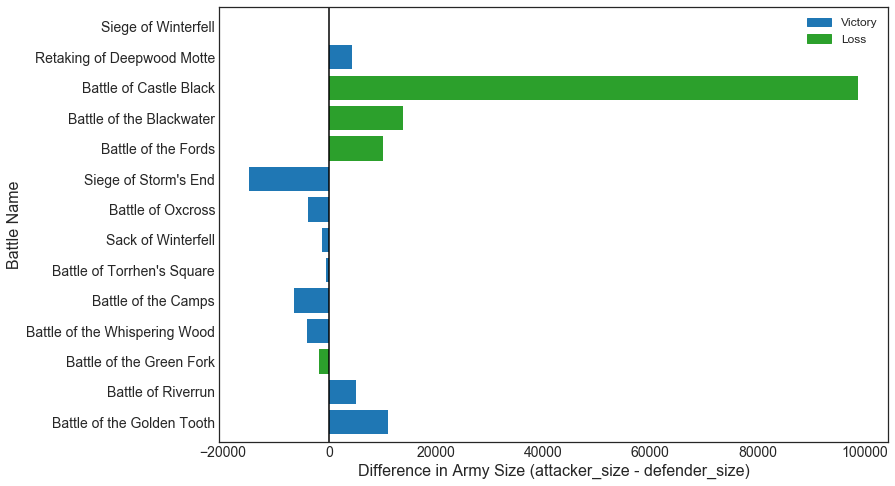

In [23]:
data = battles.dropna(subset = ["attacker_size", "defender_size"]).copy(deep = True)
data = pd.concat([(data.attacker_size - data.defender_size).to_frame(), battles[["attacker_outcome"]]], axis = 1, join = "inner")
data = data[data[0] != 0]
p = data[0].plot.barh(figsize = (12, 8), width = .8, color = [sns.color_palette()[0] if x == "win" else sns.color_palette()[2] if x == "loss" else "white" for x in data.attacker_outcome.values])
_ = p.legend(handles = [mpatches.Patch(color = sns.color_palette()[0], label = "Victory", aa = True), mpatches.Patch(color = sns.color_palette()[2], label = "Loss", aa = True)])
_ = p.axvline(0, color = 'k'), p.set(yticklabels = battles.name.iloc[data.index].values, xlabel = "Difference in Army Size (attacker_size - defender_size)", ylabel = "Battle Name")

## Как часто короли сражались в разных битвах?
Данные содержат четыре типа сражений, из которых Pitched Battle является наиболее частым и Razing наименьшим.

Оказывается, Засада, кажется, любимый тип атаки Робба Старка. Все пять его битв типа «Засада» против Джоффри / Томмена Баратеона. Робб Старк также стал мишенью для засады: дважды Балон / Еврон Грейджой и трижды Джоффри / Томмен Баратеон.

Balon (не помню этого персонажа) / Эурон Грейджой сражался с каждым типом битвы по крайней мере один раз в качестве атакующего, в то время как Джофри / Томмен Браратеон сделал это в качестве защитника.

Смотрите таблицу ниже.

C:\Users\Tatiana\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


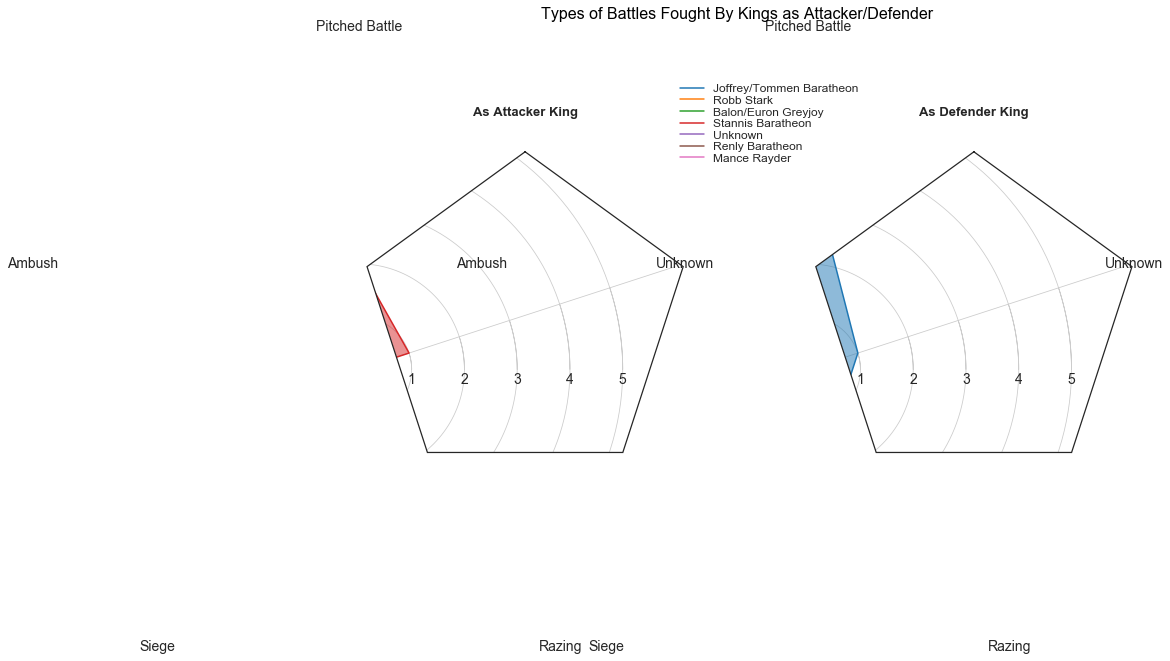

In [22]:
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection

def radar_factory(num_vars, frame = "circle"):
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint = False)
    theta += np.pi / 2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed = True, edgecolor = 'k')

    def draw_circle_patch(self):
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict: raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):
        name, RESOLUTION, draw_patch = 'radar', 1, patch_dict[frame]

        def fill(self, *args, **kwargs):
            closed = kwargs.pop("closed", True)
            return super(RadarAxes, self).fill(closed = closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines: self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == "circle": return PolarAxes._gen_axes_spines(self)
            spine_type, verts = "circle", unit_poly_verts(theta)
            verts.append(verts[0])
            path = Path(verts)
            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}
    register_projection(RadarAxes)
    return theta

def unit_poly_verts(theta):
    x0, y0, r = [0.5] * 3
    verts = [(r * np.cos(t) + x0, r * np.sin(t) + y0) for t in theta]
    return verts

kings = list(battles.attacker_king.append(battles.defender_king).fillna("Unknown").unique())
battle_types = list(battles.battle_type.fillna("Unknown").str.title().unique())

def example_data():
    data = battles[["battle_type", "attacker_king", "defender_king", "name"]].copy(deep = True).fillna("Unknown")
    data.loc[:, "battle_type"] = data.battle_type.fillna("Unknown").str.title()
    grouped, ret_data = data.groupby(["attacker_king", "battle_type"]).count()[["name"]], [battle_types]
    ret_data.append(("As Attacker King", [[grouped.loc[(kings[j], battle_types[i])].values[0]
                                    if (kings[j], battle_types[i]) in grouped.index else 0
                                    for i in range(len(battle_types))] for j in range(len(kings))]))
    grouped = data.groupby(["defender_king", "battle_type"]).count()[["name"]]
    ret_data.append(("As Defender King", [[grouped.loc[(kings[j], battle_types[i])].values[0]
                                    if (kings[j], battle_types[i]) in grouped.index else 0
                                    for i in range(len(battle_types))] for j in range(len(kings))]))
    return ret_data

N = 5
theta, data = radar_factory(N, frame = "polygon"), example_data()
spoke_labels, fig = data.pop(0), plt.figure(figsize = (14, 14))
fig.subplots_adjust(wspace = 0.35, hspace = 0.20, top = 0.85, bottom = 0.05)
colors = sns.color_palette() + ["k"]
for n, (title, case_data) in enumerate(data):
    ax, _ = fig.add_subplot(2, 2, n + 1, projection = "radar"), plt.rgrids([1, 2, 3, 4, 5])
    ax.set_title(title, weight = "bold", position = (0.5, 1.1), horizontalalignment = "center", verticalalignment = "center", fontsize = 13.)
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color = color)
        ax.fill(theta, d, facecolor = color, alpha = 0.5)
    ax.set_varlabels(spoke_labels)
plt.subplot(2, 2, 1)
labels = kings
legend = plt.legend(labels, loc = (.95, .95), labelspacing = 0.1)
plt.setp(legend.get_texts(), fontsize = "large")
plt.figtext(0.5, 0.965, "Types of Battles Fought By Kings as Attacker/Defender", ha = "center", color = "k", size = 16.)
plt.show()

In [19]:
death_preds = character_predictions.copy(deep = True)

# Попробуем попредсказывать

In [24]:
from xgboost import plot_importance
from xgboost import XGBClassifier as XGBC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score

ModuleNotFoundError: No module named 'xgboost'

### Немного предварительной обработки
Мы быстро конвертируем нечисловые категориальные функции в числовые. Затем мы отбрасываем некоторые столбцы и заменяем пропущенные значения -1.

In [25]:
death_preds.loc[:, "culture"] = [get_cult(x) for x in death_preds.culture.fillna("")]
death_preds.loc[:, "title"] = pd.factorize(death_preds.title)[0]
death_preds.loc[:, "culture"] = pd.factorize(death_preds.culture)[0]
death_preds.loc[:, "mother"] = pd.factorize(death_preds.mother)[0]
death_preds.loc[:, "father"] = pd.factorize(death_preds.father)[0]
death_preds.loc[:, "heir"] = pd.factorize(death_preds.heir)[0]
death_preds.loc[:, "house"] = pd.factorize(death_preds.house)[0]
death_preds.loc[:, "spouse"] = pd.factorize(death_preds.spouse)[0]

death_preds.drop(["name", "alive", "pred", "plod", "isAlive"], 1, inplace = True)
death_preds.columns = map(lambda x: x.replace(".", "").replace("_", ""), death_preds.columns)
death_preds.fillna(value = -1, inplace = True)

### Есть ли классовый дисбаланс?
Давайте взлянем на распределение классов.

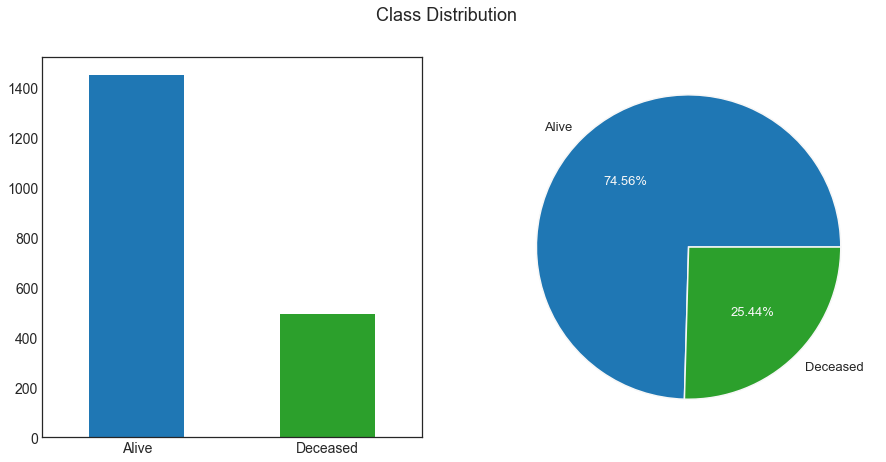

In [27]:
f, ax = plt.subplots(1, 2, figsize = (15, 7))
f.suptitle("Class Distribution", fontsize = 18.)
_ = death_preds.actual.value_counts().plot.bar(ax = ax[0], rot = 0, color = (sns.color_palette()[0], sns.color_palette()[2])).set(xticklabels = ["Alive", "Deceased"])
_ = death_preds.actual.value_counts().plot.pie(labels = ("Alive", "Deceased"), autopct = "%.2f%%", label = "", fontsize = 13., ax = ax[1],\
colors = (sns.color_palette()[0], sns.color_palette()[2]), wedgeprops = {"linewidth": 1.5, "edgecolor": "#F7F7F7"}), ax[1].texts[1].set_color("#F7F7F7"), ax[1].texts[3].set_color("#F7F7F7")

Распределение классов указывает на дисбаланс. Живых персонажей гораздо больше, чем мертвых. Есть несколько известных способов решения этой проблемы.

Двумя простейшими способами являются недостаточная выборка и избыточная выборка. В этом случае мы будем отбирать образец большинства. Мы нарисуем ~ 70% образцов без замены из меньшинства. Мы нарисуем равное количество сэмплов (~ 350) из большинства живого класса.

Используя этот разделенный тест, мы построим и сравним две модели: модель классификатора XGB и модель логистической регрессии.

In [28]:
X = death_preds[death_preds.actual == 0].sample(350, random_state = 62).append(death_preds[death_preds.actual == 1].sample(350, random_state = 62)).copy(deep = True).astype(np.float64)
Y = X.actual.values
tX = death_preds[~death_preds.index.isin(X.index)].copy(deep = True).astype(np.float64)
tY = tX.actual.values
X.drop(["SNo", "actual", "DateoFdeath"], 1, inplace = True)
tX.drop(["SNo", "actual", "DateoFdeath"], 1, inplace = True)

## XGB Classifier

In [30]:
clf_xgb = XGBC(subsample = .8, colsample_bytree = .8, seed = 14, max_depth = 3).fit(X, Y)
preds_xgb = clf_xgb.predict_proba(tX)
ax = plot_importance(clf_xgb.booster(), grid = False)
_ = ax.set(frame_on = False, ylim = (0, len(clf_xgb.booster().get_fscore())), xticklabels = "", xlabel = "")

NameError: name 'XGB' is not defined

## Logistic Regression

In [31]:
logreg = LogisticRegression(random_state = 14).fit(X, Y)
preds_lr = logreg.predict_proba(tX)

df = pd.DataFrame(list(zip(tX.columns, logreg.coef_[0])))
df = df.reindex(df[1].abs().sort_values().index).set_index(0)
ax = df.plot.barh(width = .33, legend = "", figsize = (12, 8))
ax.set_title("Logistic Regression Coefficients", y = 1.03, fontsize = 16.)
_ = ax.set(frame_on = False, xlabel = "", xticklabels = "", ylabel = "Features")

for i, label in enumerate(list(df.index)):
    score = df.ix[label][1]
    ax.annotate('%.3f' % score, (score + (-.18 if score < 0 else .02), i - .2), fontsize = 10.5)

NameError: name 'LogisticRegression' is not defined

## Сравнение классификатора XGB и логистической регрессии
Сначала мы видим матрицы смешения для обеих моделей. Мы нормализуем их по построчным суммам перед визуализацией.

NameError: name 'preds_xgb' is not defined

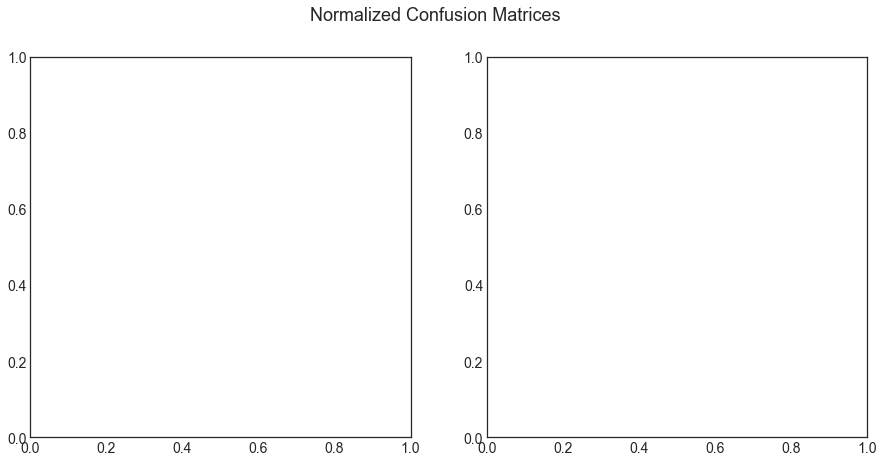

In [32]:
f, ax = plt.subplots(1, 2, figsize = (15, 7))
f.suptitle("Normalized Confusion Matrices", fontsize = 18.)
def make_cm(p, t, axis):
    cm = confusion_matrix(tY, np.argmax(p, axis = 1))
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    _ = sns.heatmap(cm, square = True, xticklabels = ["Deceased", "Alive"], annot = True,
                    annot_kws = {"fontsize": 13}, yticklabels = ["Deceased", "Alive"],
                    cbar = True, cbar_kws = {"orientation": "horizontal"}, ax = ax[axis], cmap = "Blues").set(
        xlabel = "Predicted Class", ylabel = "Actual Class", title = t)
make_cm(preds_xgb, "XGB Classifier", 0)
make_cm(preds_lr, "Logistic Regression", 1)

Далле мы посмотрим систему показателей обеих моделей. 

Мы используем удобный classification_rep и ряд других функций из sklearn.metrics, чтобы посмотреть на различные метрики оценки.

In [34]:
print("XGB Classifier Performance\n" + "=" * 26 + "\n", classification_report(tY, np.argmax(preds_xgb, axis = 1), target_names = ["Deceased", "Alive"]))
print("AUC      : %.4f" % roc_auc_score(tY, preds_xgb[:, 1]))
print("Accuracy : %.4f" % accuracy_score(tY, np.argmax(preds_xgb, axis = 1)))
print("Log Loss : %.4f\n\n" % log_loss(tY, preds_xgb[:, 1]))
print("Logistic Regression Performance\n" + "=" * 31 + "\n", classification_report(tY, np.argmax(preds_lr, axis = 1), target_names = ["Deceased", "Alive"]))
print("AUC      : %.4f" % roc_auc_score(tY, preds_lr[:, 1]))
print("Accuracy : %.4f" % accuracy_score(tY, np.argmax(preds_lr, axis = 1)))
print("Log Loss : %.4f" % log_loss(tY, preds_lr[:, 1]))

NameError: name 'classification_report' is not defined

Наконец, мы смотрим на кривые ROC для обеих моделей.

In [35]:
_ = plt.figure(figsize = (8, 8)), plt.plot(*roc_curve(tY, preds_xgb[:, 1])[:2]), plt.plot(*roc_curve(tY, preds_lr[:, 1])[:2], c = sns.color_palette()[1]), plt.legend(["XGB Classifier", "Logistic Regression"], loc = "upper left")
_ = plt.plot((0., 1.), (0., 1.), "--k", alpha = .7), plt.xlabel("False Positive Rate"), plt.ylabel("True Positive Rate"), plt.title("ROC Curves", fontsize = 16.)

NameError: name 'roc_curve' is not defined

<Figure size 576x576 with 0 Axes>

# Вот и всё! 
Спасибо, что уделили время 